In [14]:
import load_data
import feature_attender
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error

'''select  grp(BD orHC)
feature_types is the input features you want
B_1 is Dass-21 
B_2 is Altman
C is daily valence
E is daily 7 emotions
'''
dir_grp = 'HC'
feature_types = ['B_1','B_2','C','D','E']
# get attenders what u  want
attenders = feature_attender.get_wanna_attender(dir_grp,feature_types)

print(dir_grp,'attenders:',len(attenders))
# get input feature and scale (target_scale = 'ymrs' or 'hamd')
# each scale label is 4 dimension (3 factor of YMRS and 1 total score of YMRS)
x, label = load_data.loading_data(dir_grp,attenders,feature_types,target_scale='ymrs')
print('res', x.shape, label.shape)



Counting the type B_1
attender size: (222, 1)
-----------------------------------------------
Counting the type B_2
attender size: (221, 1)
-----------------------------------------------
Counting the type C
attender size: (292, 1)
-----------------------------------------------
Counting the type D
attender size: (266, 1)
-----------------------------------------------
Counting the type E
attender size: (250, 1)
-----------------------------------------------
HC attenders: 151
max (56,)
min (56,)
res: (151, 56)
x: (151, 56)
label: (151, 4)
res (151, 56) (151, 4)


extract factors

In [15]:
# get the alpha of Lasso regression
def get_alpha(x_,h_):
    global alpha_
    global check
    x_train = np.nan_to_num( x_)
    y_train = h_
    lassoCV = LassoCV(cv=10)
    lassoCV.fit( x_train, y_train)
    alpha_ = lassoCV.alpha_
    return alpha_

def Lasso_Regression(X_train,target):
    model = linear_model.Lasso(alpha=get_alpha(X_train,target))
    model.fit(X_train,target)
    return model

5-fold 

In [16]:
import numpy as np
from sklearn.model_selection import KFold
# 5-fold
kf = KFold(n_splits=5, random_state=None, shuffle=True)
pm_mae = []
im_mae = []
em_mae = []
ts_mae = []
# weight of Lasso for each factor
pm_w = []
im_w = []
em_w = []
ts_w = []

for train_index, test_index in kf.split(x):
    # 5-fold split test/train dataset
    X_test =  x[test_index]
    y_test =  label[test_index]
    
    X_train =  x[train_index]
    y_train =  label[train_index]

    print('X train:',X_train.shape)
    print('X test:',X_test.shape)
    print('Y train:',y_train.shape)
    print('Y test:',y_test.shape)
    pm_train = y_train[:,0]
    im_train = y_train[:,1]
    em_train = y_train[:,2]
    ts_train = y_train[:,3]

    pm_test = y_test[:,0]
    im_test = y_test[:,1]
    em_test = y_test[:,2]
    ts_test = y_test[:,3]

    #train
    model1 = Lasso_Regression(X_train,pm_train)
    model2 = Lasso_Regression(X_train,im_train)
    #print('model2',model2.coef_)
    model3 = Lasso_Regression(X_train,em_train)
    #print('model3',model2.coef_)
    model4 = Lasso_Regression(X_train,ts_train)
    
    pm_w.append(model1.coef_)
    im_w.append(model2.coef_)
    em_w.append(model3.coef_)
    ts_w.append(model4.coef_)
    #eva
    pm_rmae = mean_absolute_error( pm_test, model1.predict( X_test))
    im_rmae = mean_absolute_error( im_test, model2.predict( X_test))
    em_rmae = mean_absolute_error( em_test, model3.predict( X_test))
    ts_rmae = mean_absolute_error( ts_test, model4.predict( X_test))
    pm_mae.append(pm_rmae)
    im_mae.append(im_rmae)
    em_mae.append(em_rmae)
    ts_mae.append(ts_rmae)
pm_mean = sum(pm_mae) / len(pm_mae)
pm_std = np.std(pm_mae)
print('pm: %.2f ± %.2f' % (pm_mean, pm_std))
im_mean = sum(im_mae) / len(im_mae)
im_std = np.std(im_mae)
print('im: %.2f ± %.2f' % (im_mean, im_std))
em_mean = sum(em_mae) / len(em_mae)
em_std = np.std(em_mae)
print('em: %.2f ± %.2f' % (em_mean, em_std))
ts_mean = sum(ts_mae) / len(ts_mae)
ts_std = np.std(ts_mae)
print('ts: %.2f ± %.2f' % (ts_mean, ts_std))

X train: (120, 56)
X test: (31, 56)
Y train: (120, 4)
Y test: (31, 4)
X train: (121, 56)
X test: (30, 56)
Y train: (121, 4)
Y test: (30, 4)
X train: (121, 56)
X test: (30, 56)
Y train: (121, 4)
Y test: (30, 4)
X train: (121, 56)
X test: (30, 56)
Y train: (121, 4)
Y test: (30, 4)
X train: (121, 56)
X test: (30, 56)
Y train: (121, 4)
Y test: (30, 4)
pm: 0.29 ± 0.03
im: 0.36 ± 0.12
em: 0.04 ± 0.02
ts: 0.59 ± 0.10


Multi-task learning

In [17]:
Avg_mae = np.concatenate([pm_mae,im_mae,em_mae,ts_mae])
#print(Avg_mae)
print('Avg: %.2f ± %.2f' % (sum(Avg_mae)/len(Avg_mae),np.std(Avg_mae)))

Avg: 0.32 ± 0.21


draw model structure

In [18]:
Avg_mae = np.concatenate([pm_mae,im_mae,em_mae])
#print(Avg_mae)
print('Avg: %.2f ± %.2f' % (sum(Avg_mae)/len(Avg_mae),np.std(Avg_mae)))

Avg: 0.23 ± 0.16


training

In [19]:
import matplotlib.pyplot as plt

In [20]:
# mean weight in five fold
f_pm_w = np.mean(pm_w, axis=0)
f_im_w = np.mean(im_w, axis=0)
f_em_w = np.mean(em_w, axis=0)
f_ts_w = np.mean(ts_w, axis=0)

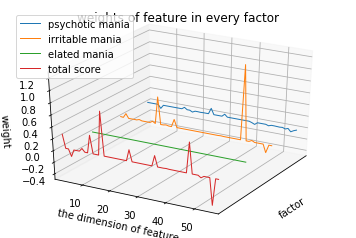

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_axis = np.arange(1,57,1)
fig = plt.figure('graph')
ax = fig.add_subplot(111, projection='3d') 

ax.set_title(r'weights of feature in every factor')

#plt.plot(x_axis , f_s_w ,color = 'b', label="sleep")
factor_dim = np.full(56,1)
ax.plot(factor_dim, x_axis , f_pm_w, linewidth=1, label=r'psychotic mania')
factor_dim = np.full(56,1.5)
ax.plot(factor_dim, x_axis , f_im_w, linewidth=1, label=r'irritable mania')
factor_dim = np.full(56,2)
ax.plot(factor_dim, x_axis , f_em_w, linewidth=1, label=r'elated mania')
factor_dim = np.full(56,2.5)
ax.plot(factor_dim, x_axis , f_ts_w, linewidth=1, label=r'total score')

ax.set_ylim(1, 57)

ax.legend(loc=2)
ax.set_xlabel('factor')
ax.set_ylabel('the dimension of feature')
ax.set_zlabel('weight')
#ax.text(0, 0, 0, 'x')  # (0,0,0)
ax.view_init(0,0)
#该函数接受两个参数，第一个参数是竖直旋转，第二个参数是水平旋转，旋转单位是度°
#ax.view_init(30, -60)
ax.set_xticks([]) 
ax.view_init(30, 30)
#plt.savefig('facotor_result/ymrs_3d'+file_grp+'.png') 
plt.show()

In [22]:
def avg_of_w_in_type(weight):
    abs_weights = np.absolute(weight)
    dimension_in_feature=[28,2,12,14]
    res_weight=np.zeros(len(dimension_in_feature))
    idx=0
    for d in range(len(dimension_in_feature)):
        if idx!=0:
            idx+=1
        for i in range(0,dimension_in_feature[d]):
            res_weight[d]+=abs_weights[idx+i]
        res_weight[d]/=dimension_in_feature[d]
        idx+=dimension_in_feature[d]-1
    print(res_weight)
    return res_weight

[0.00810785 0.02175193 0.00453236 0.00822141]
[0.02653685 0.         0.00027227 0.10183881]
[2.20294296e-18 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[0.05888704 0.         0.01546277 0.07244667]


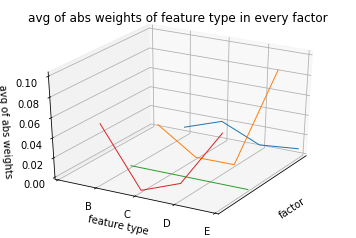

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure('graph')
ax = fig.add_subplot(111, projection='3d') 

ax.set_title(r'avg of abs weights of feature type in every factor')

res_each_factor=[]
#plt.plot(x_axis , f_s_w ,color = 'b', label="sleep")
x_axis = np.arange(1,5,1)

factor_dim = np.full(4,1)
res = avg_of_w_in_type(f_pm_w)
res_each_factor.append(res)
ax.plot(factor_dim, x_axis , res, linewidth=1, label=r'psychotic mania')
factor_dim = np.full(4,1.5)
res = avg_of_w_in_type(f_im_w)
res_each_factor.append(res)
ax.plot(factor_dim, x_axis , res, linewidth=1, label=r'irritable mania')
factor_dim = np.full(4,2)
res = avg_of_w_in_type(f_em_w)
res_each_factor.append(res)
ax.plot(factor_dim, x_axis , res, linewidth=1, label=r'elated mania')
factor_dim = np.full(4,2.5)
res = avg_of_w_in_type(f_ts_w)
res_each_factor.append(res)
ax.plot(factor_dim, x_axis , res, linewidth=1, label=r'total score')

ax.set_ylim(0, 4)
#ax.legend(loc=1)
ax.set_xlabel('factor')
ax.set_ylabel('feature type')
ax.set_zlabel('avg of abs weights')
#ax.text(0, 0, 0, 'x')  # (0,0,0)
ax.view_init(0,0)
#该函数接受两个参数，第一个参数是竖直旋转，第二个参数是水平旋转，旋转单位是度°
ax.set_xticks([])
ax.set_yticks((0,1,2,3,4))
ax.set_yticklabels((" ","B","C","D","E"))
ax.view_init(30, 30)
#plt.savefig('facotor_result/ymrs_3d'+file_grp+'.png') 
plt.show()

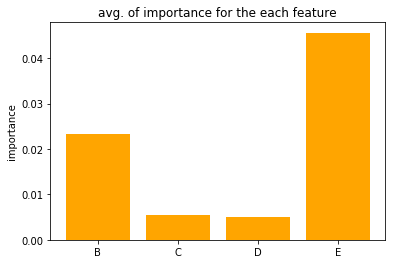

In [24]:
res_each_factor = np.array(res_each_factor)
each_weights_in_type = np.mean(res_each_factor, axis=0)
x_axis = np.arange(1,5,1)
plt.title(r'avg. of importance for the each feature')
plt.bar(x_axis , each_weights_in_type ,color = 'orange', label="weight")
#plt.xlabel('feature type')
plt.ylabel('importance')
plt.xticks([])
x_ori = [1,2,3,4]
labels = ['B','C','D','E']
plt.xticks(x_axis, labels)
plt.show()